# SedonaDB + FlatGeobuf

This page explains how to read FlatGeobuf files with SedonaDB.

FlatGeobuf is a cloud-optimized binary format for geographic vector data designed for fast streaming and spatial filtering over HTTP.  It has a built-in spatial index, is easily compactible, contains CRS information, and is supported by many engines.

SedonaDB is well-suited for reading FlatGeobuf files because it can leverage the FlatGeobuf index to read only a portion of the file.

The examples on this page show you how to query FlatGeobuf files with SedonaDB over HTTP.

In [3]:
import sedona.db

sd = sedona.db.connect()

## Read Microsoft Buildings FlatGeobuf data with SedonaDB

The Microsoft buildings dataset is a comprehensive open dataset of building footprints extracted from satellite imagery using computer vision and deep learning.

Here's how to read the Microsoft buildings dataset into a SedonaDB DataFrame and print a few rows.

In [12]:
url = "https://github.com/geoarrow/geoarrow-data/releases/download/v0.2.0/microsoft-buildings_point.fgb.zip"
df = sd.read_pyogrio(url)
df.show(3)

┌─────────────────────────────────┐
│           wkb_geometry          │
│             geometry            │
╞═════════════════════════════════╡
│ POINT(-97.16154292 26.08759861) │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ POINT(-97.1606625 26.08481)     │
├╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ POINT(-97.16133375 26.08519809) │
└─────────────────────────────────┘


You can see that the Microsoft Buildings dataset contains the building centroids.

Take a look at the schema and see how it contains the `wkb_geometry` column and the CRS.

In [13]:
df.schema

SedonaSchema with 1 field:
  wkb_geometry: geometry<Wkb(ogc:crs84)>

Now lets see how to read another FlatGeobuf dataset.

## Read Vermont boundary FlatGeobuf data with SedonaDB

The Vermont boundary dataset contains the polygon for the state of Vermont.

The following example shows how to read the Vermont FlatGeobuf dataset and plot it.

<Axes: >

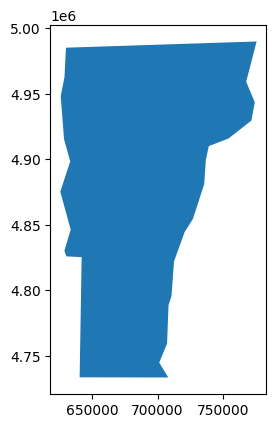

In [11]:
url = "https://raw.githubusercontent.com/geoarrow/geoarrow-data/v0.2.0/example-crs/files/example-crs_vermont-utm.fgb"
sd.read_pyogrio(url).to_pandas().plot()

## Read a portion of a large remote FlatGeobuf file

Now let's look at how to read a portion of a 12GB FlatGeobuf file.

In [7]:
%%time

url = "https://flatgeobuf.septima.dk/population_areas.fgb"
sd.read_pyogrio(url).to_view("population_areas", True)

wkt = "POLYGON ((-73.978329 40.767412, -73.950005 40.767412, -73.950005 40.795098, -73.978329 40.795098, -73.978329 40.767412))"
sd.sql(
    f"""
SELECT sum(population::INTEGER) FROM population_areas
WHERE ST_Intersects(wkb_geometry, ST_SetSRID(ST_GeomFromWKT('{wkt}'), 4326))
"""
).show()

┌──────────────────────────────────┐
│ sum(population_areas.population) │
│               int64              │
╞══════════════════════════════════╡
│                           256251 │
└──────────────────────────────────┘
CPU times: user 16 ms, sys: 15.3 ms, total: 31.4 ms
Wall time: 493 ms


SedonaDB can query the 12GB FlatGeobuf file in about half of a second on a laptop for this area of interest.